In [4]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import CondensedNearestNeighbour

In [5]:
def make_data(sep):
    """
    `make_data` creates artificial data using sklearn `make_classification` function.
    It returns a pandas DataFrame that consists of 2 features and the a 2-class target 
    column.

    sep [float]: The factor multiplying the hypercube size. Larger values spread out the 
    clusters/classes and make the classification task easier.
    """
    X, y = make_classification(
        n_samples=1000,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[0.99],
        class_sep=sep,
        random_state=42
    )

    X = pd.DataFrame(X, columns=["varA", "varB"])
    y = pd.Series(y)
    return X, y


 0    985
1     15
dtype: int64


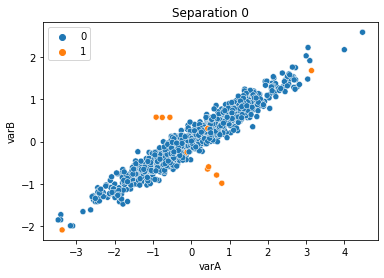


 0    985
1     15
dtype: int64


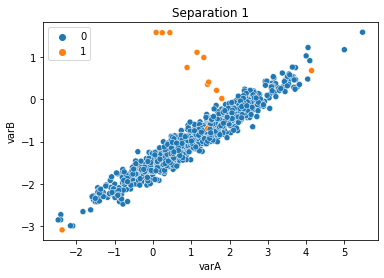


 0    985
1     15
dtype: int64


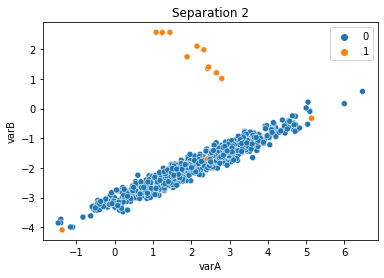

In [6]:
# Visualization of data used in this notebook
for sep in np.arange(0, 3):
    X, y = make_data(sep)
    print(f"\n {y.value_counts()}")
    sns.scatterplot(data=X, x="varA", y="varB", hue=y)
    plt.title(f"Separation {sep}")
    plt.show()

## Undersampling with condensed nearest neighbours

### Well-separated classes

In [8]:
X, y = make_data(sep=2)

cnn = CondensedNearestNeighbour(sampling_strategy="auto", n_neighbors=1, random_state=42)
X_resampled, y_resampled = cnn.fit_resample(X, y)

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [13]:
y.value_counts()

0    985
1     15
dtype: int64

In [11]:
X_resampled.shape, y_resampled.shape

((43, 2), (43,))

In [12]:
y_resampled.value_counts()

0    28
1    15
dtype: int64

Text(0.5, 1.0, 'Undersampled dataset')

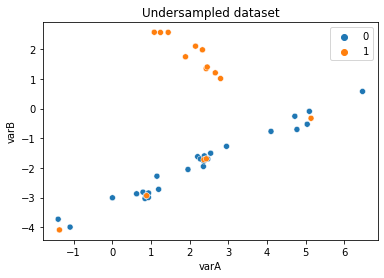

In [15]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)
plt.title("Undersampled dataset")